Downloading the data


In [1]:
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
from google.colab import drive
drive.mount('/content/drive')

!kaggle competitions download -c dogs-vs-cats

!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

Saving kaggle.json to kaggle.json
Mounted at /content/drive
 97% 787M/812M [00:04<00:00, 187MB/s]
100% 812M/812M [00:04<00:00, 191MB/s]


Copying images to training, validation, and test directories




In [2]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

Question 1:- Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (half the sample size as the sample Jupyter notebook on Canvas). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

Let's train a model from scratch. The model 1 has a Training sample of 1000, a validation sample of 500, and a test sample of 500

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
(16,)
(16,)
(16,)
(32, 16)
(32, 16)
(32, 16)
(4, 4)
(4, 4)
(4, 4)
data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


Epoch 1/50
63/63 [==============================] - 16s 58ms/step - loss: 0.6984 - accuracy: 0.4970 - val_loss: 0.6946 - val_accuracy: 0.5000
Epoch 2/50
63/63 [==============================] - 3s 44ms/step - loss: 0.6935 - accuracy: 0.5275 - val_loss: 0.7066 - val_accuracy: 0.5020
Epoch 3/50
63/63 [==============================] - 3s 47ms/step - loss: 0.6918 - accuracy: 0.5635 - val_loss: 0.6704 - val_accuracy: 0.5930
Epoch 4/50
63/63 [==============================] - 3s 44ms/step - loss: 0.6683 - accuracy: 0.6125 - val_loss: 0.6662 - val_accuracy: 0.6010
Epoch 5/50
63/63 [==============================] - 3s 43ms/step - loss: 0.6579 - accuracy: 0.6230 - val_loss: 0.6237 - val_accuracy: 0.6350
Epoch 6/50
63/63 [==============================] - 3s 43ms/step - loss: 0.6171 - accuracy: 0.6600 - val_loss: 0.6598 - val_accuracy: 0.5880
Epoch 7/50
63/63 [==============================] - 3s 47ms/step - loss: 0.6036 - accuracy: 0.6840 - val_loss: 0.6079 - val_accuracy: 0.6580
Epoch 8/50
6

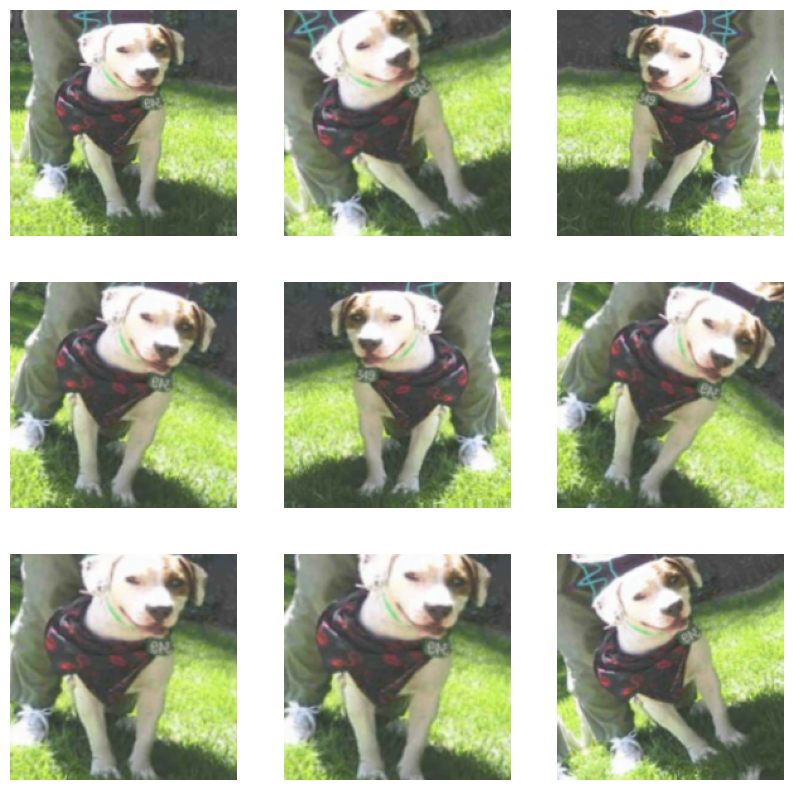

In [4]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True, 
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)


test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

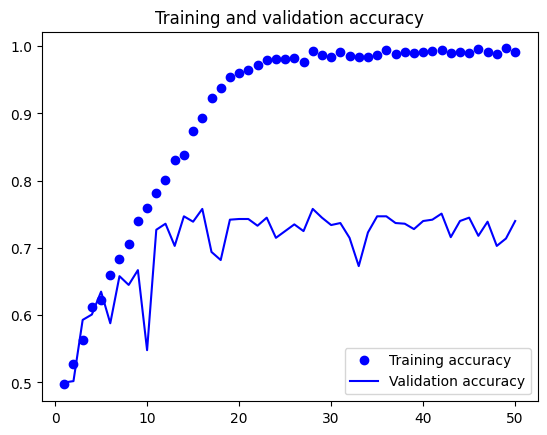

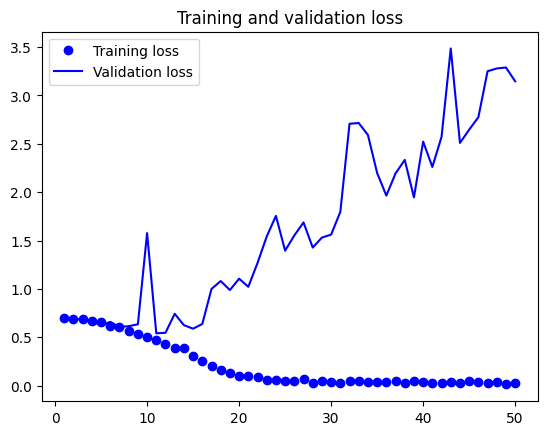

In [5]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()


Question 2: Increase your training sample size. You may pick any amount. Keep the validation and test samples the same as above. Optimize your network (again training from scratch). What performance did you achieve?

The second model we are increasing training sample and keeping validation sample of 500, and a test sample of 500.

In [6]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_2", start_index=0, end_index=3000)
make_subset("validation_2", start_index=3000, end_index=3500)
make_subset("test_2", start_index=3500, end_index=4000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_2",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_2",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_2",
    image_size=(180, 180),
    batch_size=32)

Found 6000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Epoch 1/50
188/188 [==============================] - 9s 40ms/step - loss: 0.8605 - accuracy: 0.5287 - val_loss: 0.6746 - val_accuracy: 0.6240
Epoch 2/50
188/188 [==============================] - 7s 38ms/step - loss: 0.6631 - accuracy: 0.6125 - val_loss: 0.6313 - val_accuracy: 0.6600
Epoch 3/50
188/188 [==============================] - 7s 38ms/step - loss: 0.6315 - accuracy: 0.6570 - val_loss: 0.6071 - val_accuracy: 0.6780
Epoch 4/50
188/188 [==============================] - 7s 38ms/step - loss: 0.6107 - accuracy: 0.6770 - val_loss: 0.6065 - val_accuracy: 0.6770
Epoch 5/50
188/188 [==============================] - 8s 39ms/step - loss: 0.5906 - accuracy: 0.6930 - val_loss: 0.5748 - val_accuracy: 0.7100
Epoch 6/50
188/188 [==============================] - 8s 39ms/step - loss: 0.5615 - accuracy: 0.7153 - val_loss: 0.5379 - val_accuracy: 0.7250
Epoch 7/50
188/188 [==============================] - 7s 37ms/step - loss: 0.5301 - accuracy: 0.7443 - val_loss: 0.4976 - val_accuracy: 0.7670

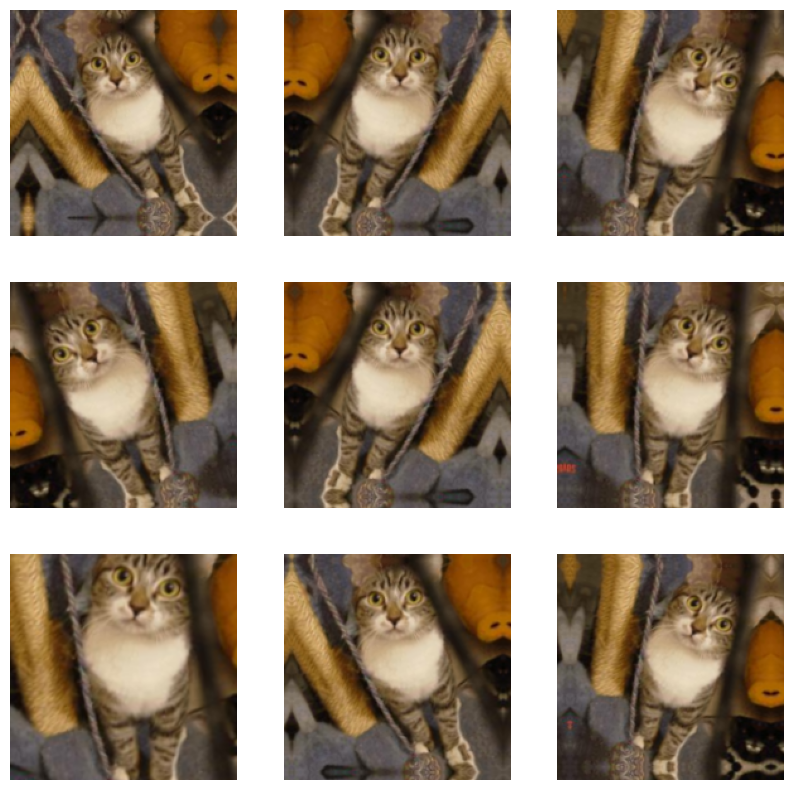

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)






test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

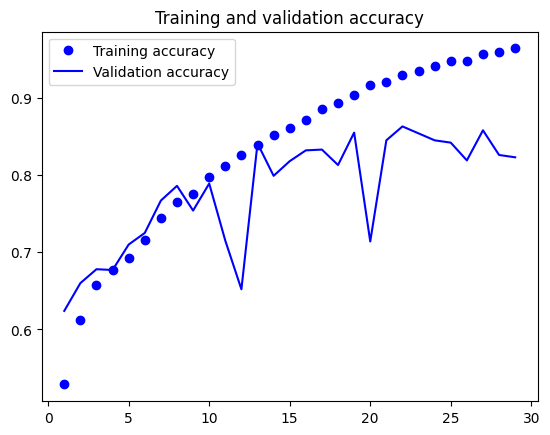

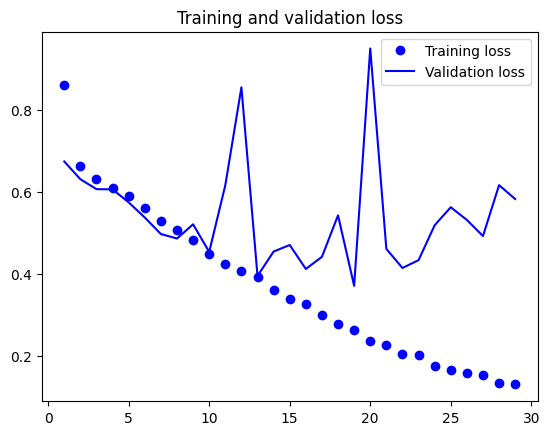

In [8]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Question 3 :- Now change your training sample so that you achieve better performance than those from Steps 1 and 2. This sample size may be larger, or smaller than those in the previous steps. The objective is to find the ideal training sample size to get best prediction results.

Now, the third model will have 9000 training samples we will keep the same validation sample of 500, and a test sample of 500.

In [9]:
from tensorflow.keras.utils import image_dataset_from_directory


make_subset("train_3", start_index=0, end_index=9000)
make_subset("validation_3", start_index=9000, end_index=9500)
make_subset("test_3", start_index=9500, end_index=10000)

train_dataset = image_dataset_from_directory(
    new_base_dir / "train_3",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation_3",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test_3",
    image_size=(180, 180),
    batch_size=32)

Found 18000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


Epoch 1/50
563/563 [==============================] - 22s 36ms/step - loss: 0.7378 - accuracy: 0.5806 - val_loss: 0.8352 - val_accuracy: 0.5370
Epoch 2/50
563/563 [==============================] - 20s 35ms/step - loss: 0.5862 - accuracy: 0.6948 - val_loss: 0.6015 - val_accuracy: 0.7080
Epoch 3/50
563/563 [==============================] - 20s 35ms/step - loss: 0.5139 - accuracy: 0.7561 - val_loss: 0.4701 - val_accuracy: 0.7900
Epoch 4/50
563/563 [==============================] - 20s 35ms/step - loss: 0.4600 - accuracy: 0.7957 - val_loss: 0.4948 - val_accuracy: 0.7730
Epoch 5/50
563/563 [==============================] - 20s 35ms/step - loss: 0.4082 - accuracy: 0.8256 - val_loss: 0.4992 - val_accuracy: 0.7570
Epoch 6/50
563/563 [==============================] - 20s 35ms/step - loss: 0.3726 - accuracy: 0.8439 - val_loss: 0.3444 - val_accuracy: 0.8680
Epoch 7/50
563/563 [==============================] - 20s 35ms/step - loss: 0.3316 - accuracy: 0.8649 - val_loss: 0.3242 - val_accuracy:

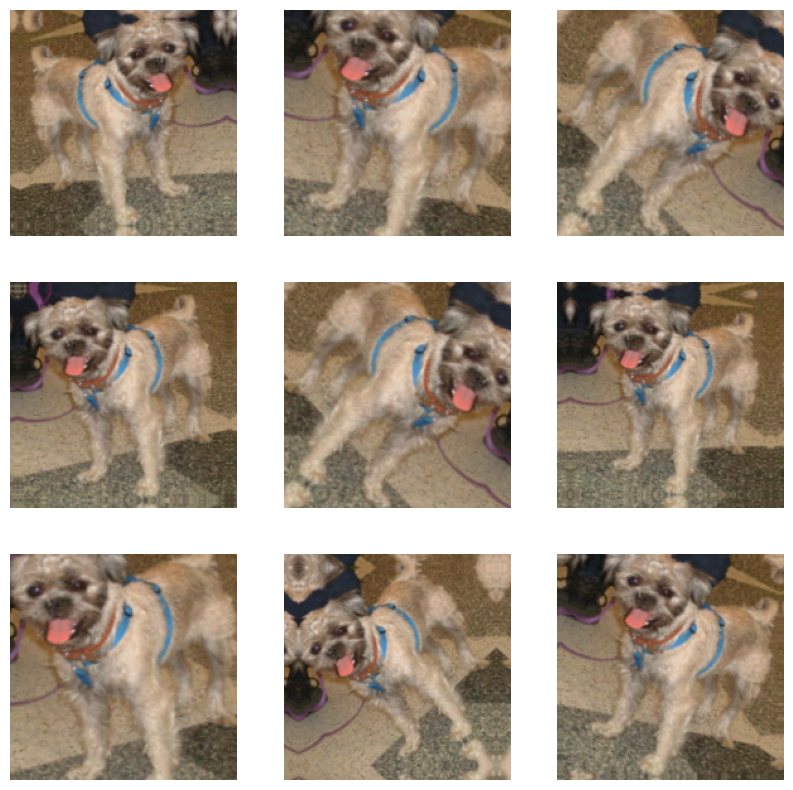

In [10]:
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from keras import regularizers
# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu",kernel_regularizer = regularizers.l2( l=0.01))(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics=["accuracy"])


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)




test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

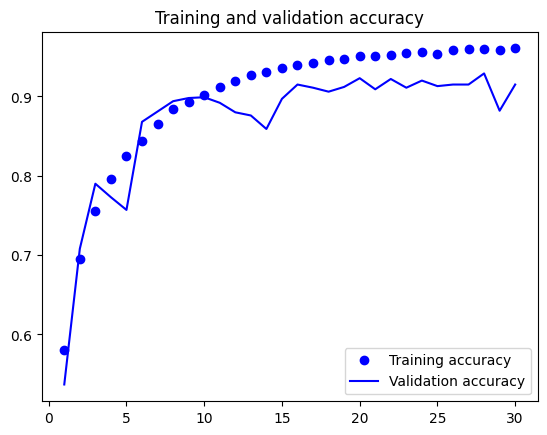

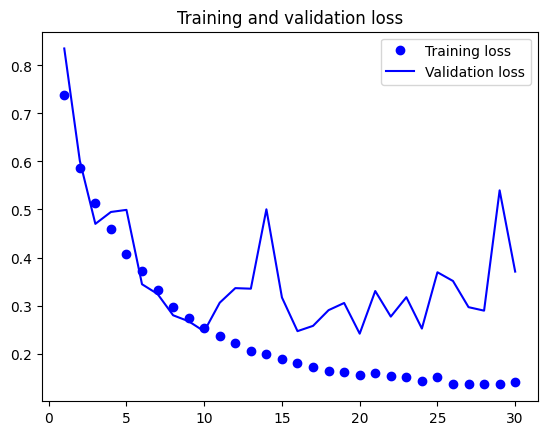

In [11]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Question 4 :- Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 for the pretrained network may be the same or different from those using the network where you trained from scratch. Again, use any and all optimization techniques to get best performance.

Pretrained Model1:- Training sample of 2000, a validation sample of 1000, and a test sample of 1000.

VGG16 Pretrained Convnet Network

Using Feature Extraction with Data Augmentation and Fine-tuning

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
563/563 [==============================] - 20s 35ms/step - loss: 0.1318 - accuracy: 0.9628 - val_loss: 0.5560 - val_accuracy: 0.8910
Epoch 2/50
563/563 [==============================] - 20s 36ms/step - loss: 0.1486 - accuracy: 0.9597 - val_loss: 0.5275 - val_accuracy: 0.9050
Epoch 3/50
563/563 [==============================] - 20s 35ms/step - loss: 0.1261 - accuracy: 0.9653 - val_loss: 0.4465 - val_accuracy: 0.9020
Epoch 4/50
563/563 [==============================] - 20s 35ms/step - loss: 0.1186 - accuracy: 0.9669 - val_loss: 0.4384 - val_accuracy: 0.9090
Epoch 5/50
563/563 [==============================] - 20s 35ms/step - loss: 0.1314 - accuracy: 0.9648 - val_loss: 0.3583 - val_accuracy: 0.9110
Epoch 6/50
563/563 [==============================] - 20s 35ms/step - loss: 0.1227 - accuracy: 0.9659 - val_loss: 1.4813 - val_accuracy: 0.8280
Epoch 7/50
563/563 [==============================] - 20s 35ms/step - l

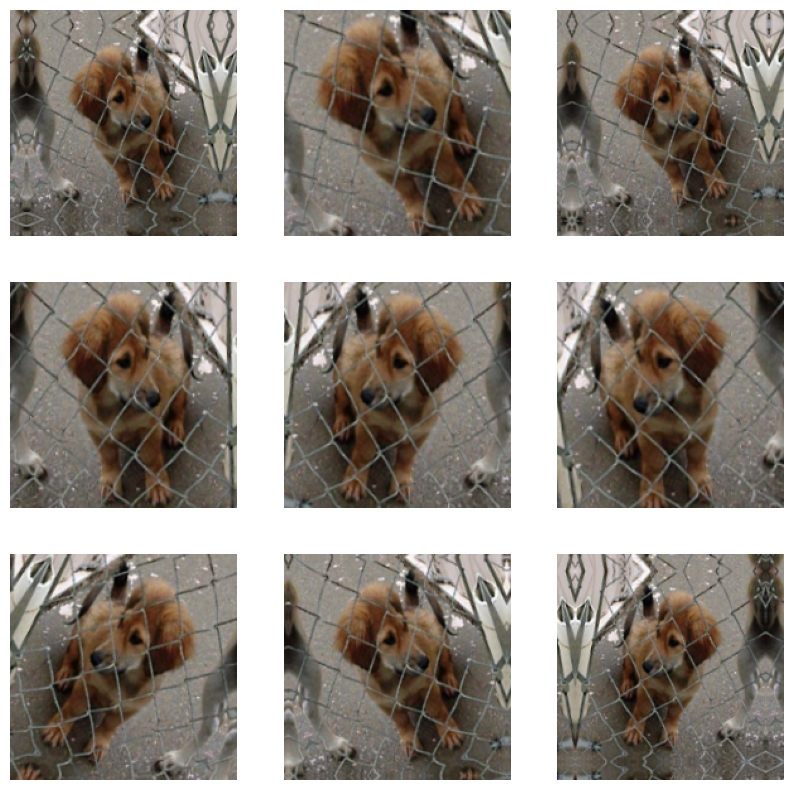

32/32 [==============================] - 1s 18ms/step - loss: 0.3339 - accuracy: 0.9040
Test accuracy: 0.904


In [12]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the VGG16 convolutional base
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_1 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_1.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()

test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

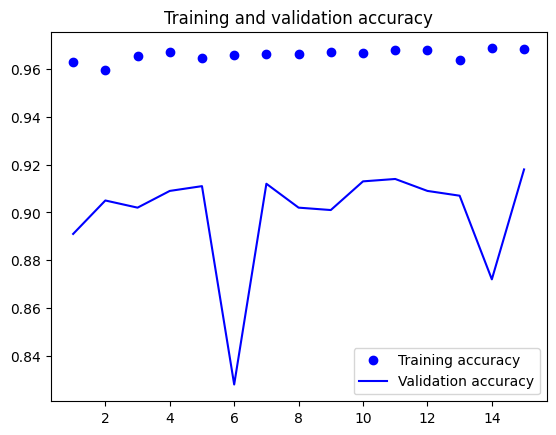

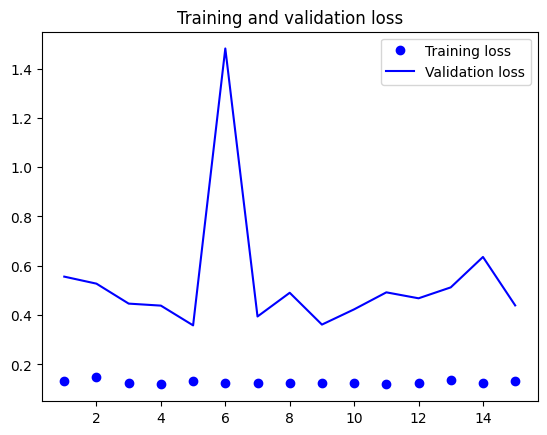

In [13]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Pretrained Model 2: ResNet50V2 convolutional base 

94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/50
563/563 [==============================] - 57s 92ms/step - loss: 0.2473 - accuracy: 0.9461 - val_loss: 0.1370 - val_accuracy: 0.9760
Epoch 2/50
563/563 [==============================] - 49s 86ms/step - loss: 0.1871 - accuracy: 0.9657 - val_loss: 0.1478 - val_accuracy: 0.9750
Epoch 3/50
563/563 [==============================] - 49s 86ms/step - loss: 0.1631 - accuracy: 0.9707 - val_loss: 0.1573 - val_accuracy: 0.9790
Epoch 4/50
563/563 [==============================] - 49s 86ms/step - loss: 0.1402 - accuracy: 0.9743 - val_loss: 0.1804 - val_accuracy: 0.9800
Epoch 5/50
563/563 [==============================] - 49s 86ms/step - loss: 0.1342 - accuracy: 0.9775 - val_loss: 0.1607 - val_accuracy: 0.9770
Epoch 6/50
563/563 [==============================] - 50s 88ms/step - loss: 0.1194 - accuracy: 0.9778 - val_loss: 0.1257 - val_accuracy: 0.9830
Epoch 7/50
563/563 [==============================] - 49s 86ms/step - l

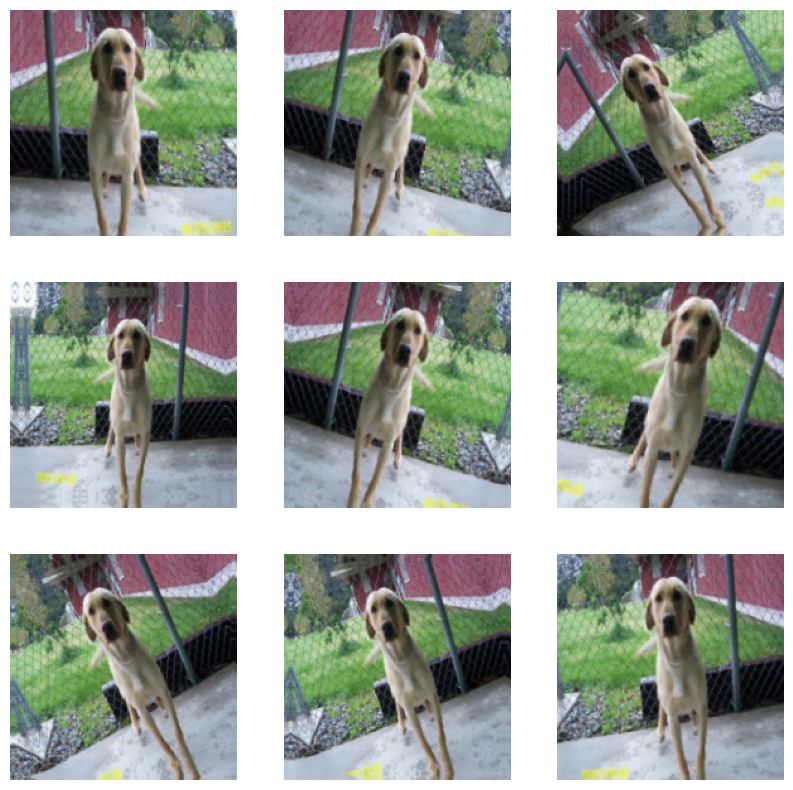

32/32 [==============================] - 3s 68ms/step - loss: 0.1331 - accuracy: 0.9820
Test accuracy: 0.982


In [14]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50

# Instantiating the ResNet50 convolutional base
conv_base = ResNet50(weights='imagenet',
                     include_top=False,
                     input_shape=(180, 180, 3))

# Freezing all layers until the fifth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-5]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.resnet50.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_2 = keras.Model(inputs, outputs)

# Fine-tuning the model
model_pre_trained_2.compile(loss="binary_crossentropy",
                            optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                            metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]

history = model_pre_trained_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()


test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


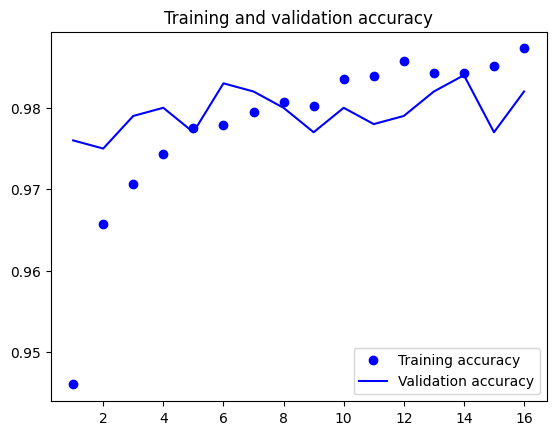

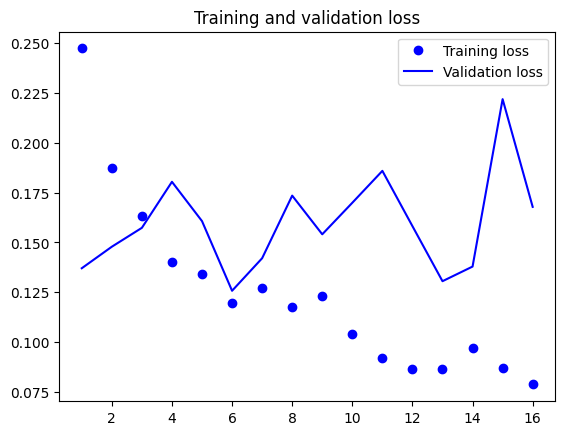

In [15]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

Pretrained Model 3 : MobileNetV2 

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/50
563/563 [==============================] - 25s 37ms/step - loss: 0.7681 - accuracy: 0.6279 - val_loss: 0.2815 - val_accuracy: 0.8920
Epoch 2/50
563/563 [==============================] - 19s 34ms/step - loss: 0.4024 - accuracy: 0.8292 - val_loss: 0.1522 - val_accuracy: 0.9460
Epoch 3/50
563/563 [==============================] - 20s 35ms/step - loss: 0.2831 - accuracy: 0.8873 - val_loss: 0.1102 - val_accuracy: 0.9670
Epoch 4/50
563/563 [==============================] - 19s 34ms/step - loss: 0.2320 - accuracy: 0.9103 - val_loss: 0.0929 - val_accuracy: 0.9710
Epoch 5/50
563/563 [==============================] - 19s 34ms/step - loss: 0.1895 - accuracy: 0.9268 - val_loss: 0.0836 - val_accuracy: 0.9740
Epoch 6/50
563/563 [==============================] - 19s 34ms/step - loss: 0.1727 - accuracy: 0.9348 - val_loss: 0.0765 - val_accuracy: 0.9750
Epoch 7/50
563/563 [==============================] - 19s 34ms/step - los

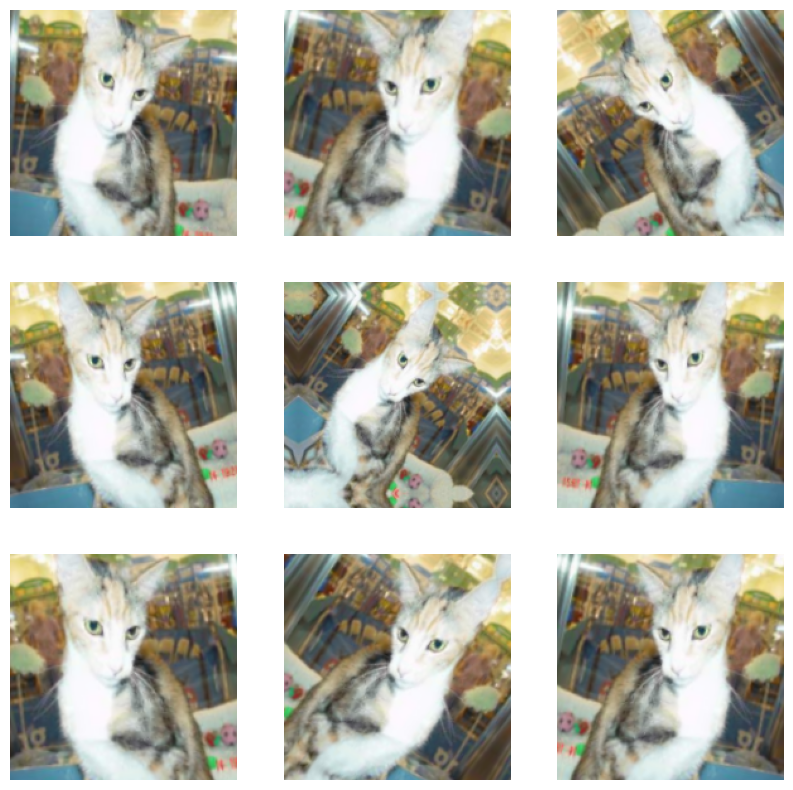

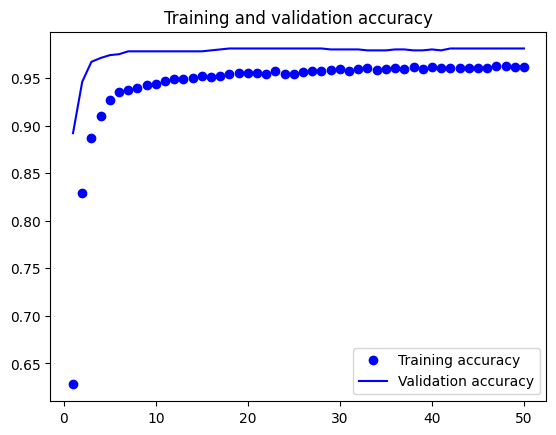

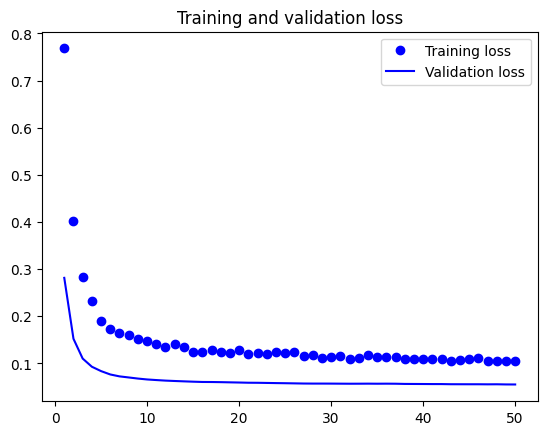

32/32 [==============================] - 2s 29ms/step - loss: 0.0434 - accuracy: 0.9860
Test accuracy: 0.986


In [16]:
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

# Instantiating the MobileNetV2 convolutional base
conv_base  = keras.applications.MobileNetV2(
    weights="imagenet",
    include_top=False)

# Freezing all layers until the fourth from the last
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

# Adding a data augmentation stage and a classifier to the convolutional base
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.mobilenet_v2.preprocess_input(x)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_pre_trained_2 = keras.Model(inputs, outputs)
# Fine-tuning the model
model_pre_trained_2.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-6),
              metrics=["accuracy"])

# Define early_stopping_monitor
# used early stopping to stop optimization when it isn't helping any more. 
early_stopping_monitor = EarlyStopping(patience=10)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_2.keras",
        save_best_only=True,
        monitor="val_loss"), early_stopping_monitor
]
history = model_pre_trained_2.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

plt.show()


# Evaluate the model on the test set
test_model = keras.models.load_model("convnet_from_scratch_2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


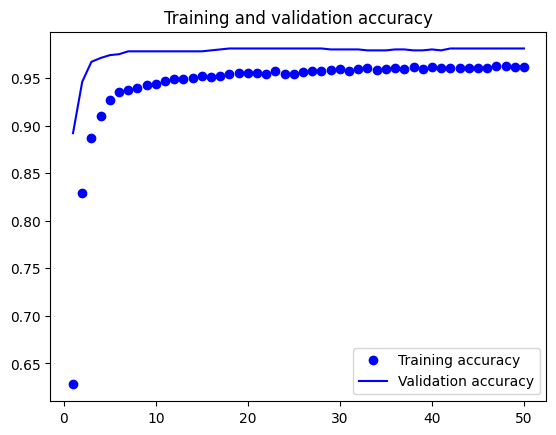

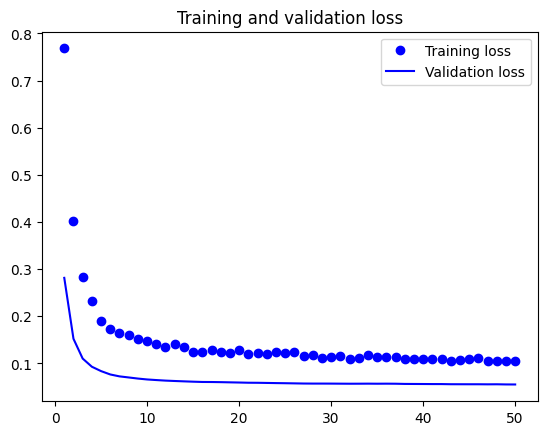

In [17]:
# Plotting the results
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()